### Importing libraries

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import warnings

warnings.filterwarnings("ignore")

### Load the dataset

In [2]:
# Load files into a pandas dataframe
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
test_ = pd.read_csv("Test.csv")
ss = pd.read_csv("SampleSubmission.csv")
variables = pd.read_csv("VariableDefinitions.csv")

In [3]:
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [4]:
# Let’s observe the shape of our datasets.
print("train data shape :", train.shape)
print("test data shape :", test.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


In [5]:
# inspect train data
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [6]:
# inspect test data
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [7]:
# Check for missing values
train.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train["country"] = le.fit_transform(train["country"])
train["bank_account"] = le.fit_transform(train["bank_account"])


test["country"] = le.fit_transform(test["country"])

In [9]:
# Onehot encode feature variables
from feature_engine.encoding import OneHotEncoder


cat_cols = [
    "location_type",
    "cellphone_access",
    "gender_of_respondent",
    "relationship_with_head",
    "marital_status",
    "education_level",
    "job_type",
]


def onehot_encoder(df, cat_cols):
    ohe = OneHotEncoder(variables=cat_cols)


    df = ohe.fit_transform(df)
    return df


train = onehot_encoder(train, cat_cols)
test = onehot_encoder(test, cat_cols)


In [10]:
# Variable discretizer
from feature_engine.discretisation import EqualFrequencyDiscretiser

variable = ["household_size", "age_of_respondent"]


def discretizer(df, variable):
    efd = EqualFrequencyDiscretiser()
    df[variable] = efd.fit_transform(df[variable])


discretizer(train, variable)
discretizer(test, variable)

In [11]:
# Transform variables using the YoeJohnsonTransformer
from feature_engine.transformation import YeoJohnsonTransformer

ytj = YeoJohnsonTransformer()
train[["household_size", "age_of_respondent"]] = ytj.fit_transform(
    train[["household_size", "age_of_respondent"]]
)
test[["household_size", "age_of_respondent"]] = ytj.fit_transform(
    test[["household_size", "age_of_respondent"]]
)

In [12]:
# Create new math features with sum
from feature_engine.creation import MathFeatures

variable = ["household_size", "age_of_respondent"]
mf = MathFeatures(variables=variable, func="sum")

train = mf.fit_transform(train)
test = mf.fit_transform(test)

In [13]:
# Create X and y variables
X = train.drop(
    columns=["uniqueid", "bank_account"]
)  
y = train["bank_account"]
X_test = test.drop(
    columns=["uniqueid"]
)  

In [14]:
y[:6]

0    1
1    0
2    1
3    0
4    0
5    0
Name: bank_account, dtype: int32

In [15]:
X.head()

,country,year,household_size,age_of_respondent,location_type_Rural,location_type_Urban,cellphone_access_Yes,cellphone_access_No,gender_of_respondent_Female,gender_of_respondent_Male,...,job_type_Government Dependent,job_type_Formally employed Private,job_type_Informally employed,job_type_Formally employed Government,job_type_Farming and Fishing,job_type_Remittance Dependent,job_type_Other Income,job_type_Dont Know/Refuse to answer,job_type_No Income,sum_household_size_age_of_respondent
0,0,2018,0.677237,0.886643,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1.563880
1,0,2018,1.323624,5.595855,1,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,6.919479
2,0,2018,1.323624,1.636981,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,2.960605
3,0,2018,1.323624,2.932301,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,4.255925
4,0,2018,1.823942,1.636981,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,3.460923


In [16]:
# Split data into training and validation data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score

# Create a CatBoost Pool for training and validation data
train_pool = Pool(data=X_Train, label=y_Train)
val_pool = Pool(data=X_Val, label=y_val)

# Define CatBoost parameters
catboost_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "learning_rate": 0.04162,
    "iterations": 65,
    "random_seed": 42,
    "depth": 12,
    "border_count": 32,
    "od_type": "Iter",
    "early_stopping_rounds": 700,
    "task_type": "CPU",
    "logging_level": "Verbose",
    "min_child_samples": 10,
    "l2_leaf_reg": 5,  
    "bagging_temperature": 5,

}

# Create and train the CatBoost model
model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=val_pool)

# Make predictions on the validation set
y_pred = model.predict(X_Val)

# Convert predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate the error rate
error_rate = 1 - accuracy_score(y_val, y_pred_binary)
print(f"Error rate of CatBoost classifier: {error_rate:.4f}")

0:	test: 0.8233680	best: 0.8233680 (0)	total: 62.3ms	remaining: 3.99s
1:	test: 0.8461241	best: 0.8461241 (1)	total: 98.1ms	remaining: 3.09s
2:	test: 0.8564793	best: 0.8564793 (2)	total: 134ms	remaining: 2.78s
3:	test: 0.8581431	best: 0.8581431 (3)	total: 155ms	remaining: 2.37s
4:	test: 0.8633042	best: 0.8633042 (4)	total: 164ms	remaining: 1.97s
5:	test: 0.8634770	best: 0.8634770 (5)	total: 197ms	remaining: 1.93s
6:	test: 0.8643242	best: 0.8643242 (6)	total: 206ms	remaining: 1.71s
7:	test: 0.8647568	best: 0.8647568 (7)	total: 216ms	remaining: 1.54s
8:	test: 0.8663074	best: 0.8663074 (8)	total: 252ms	remaining: 1.57s
9:	test: 0.8658515	best: 0.8663074 (8)	total: 258ms	remaining: 1.42s
10:	test: 0.8685658	best: 0.8685658 (10)	total: 294ms	remaining: 1.44s
11:	test: 0.8682959	best: 0.8685658 (10)	total: 303ms	remaining: 1.34s
12:	test: 0.8680178	best: 0.8685658 (10)	total: 336ms	remaining: 1.34s
13:	test: 0.8690581	best: 0.8690581 (13)	total: 373ms	remaining: 1.36s
14:	test: 0.8688073	best

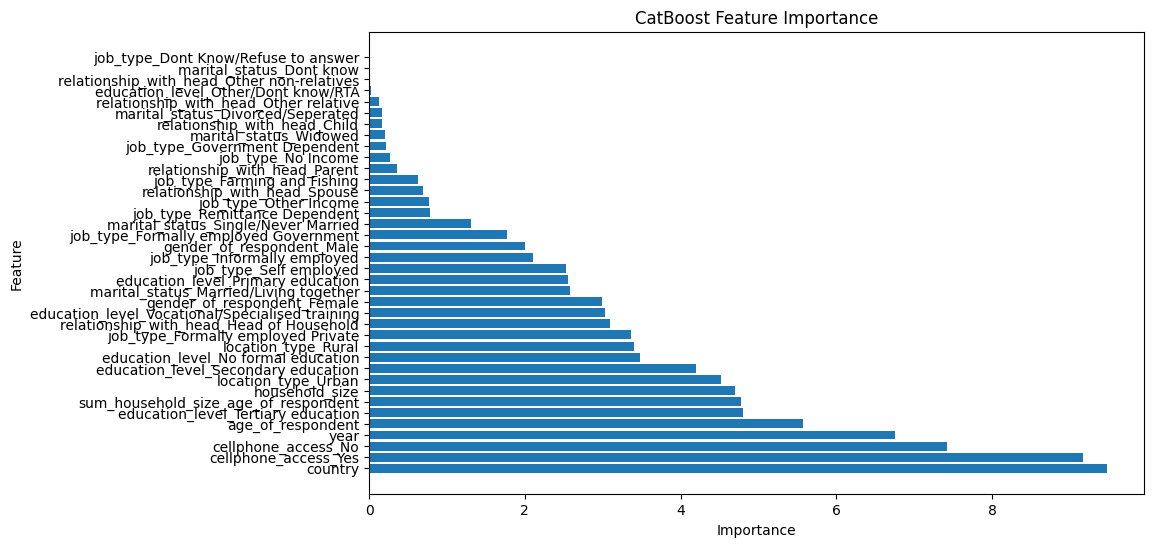

In [99]:
# Plot feature importance
import pandas as pd

feature_importance = model.get_feature_importance(prettified=True)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature Id"], feature_importance["Importances"])
plt.yticks(feature_importance["Feature Id"], feature_importance["Feature Id"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.show()

In [100]:
# Get the predicted result for the test Data
test.bank_account = model.predict(X_test)

In [101]:
# Create submission DataFrame
submission = pd.DataFrame(
    {
        "uniqueid": test["uniqueid"] + " x " + test_["country"],
        "bank_account": test.bank_account,
    }
)

In [102]:
# first few in submission file
submission.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0


In [97]:
# Create submission csv file csv file
submission.to_csv("first_submission_2.csv", index=False)